# Traffic Sign Recognition Classifier

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
assert(physical_devices)

In [4]:
print(physical_devices)
if len(physical_devices):
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# imports
import numpy as np
import pickle
import os

In [6]:
output_dir = "./output" # directory for generated graphics and images

---
## Loading traffic sign data 

In [7]:
# Load pickled data

data_dir = "./traffic-signs-data"
training_file = os.sep.join([data_dir, "train.p"])
validation_file= os.sep.join([data_dir, "valid.p"])
testing_file = os.sep.join([data_dir, "test.p"])

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [8]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)

print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from traffic_sign_classifier.utils import group_by_category, load_signnames
# Loading the classes/categories names
class2label = load_signnames(os.sep.join([data_dir, "signnames.csv"]))

# by_category_sample = group_by_category(y_train)

In [11]:
os.path.join(output_dir, "images_preview.jpg")

'./output/images_preview.jpg'

#### Traffic sign images preview for all the classes

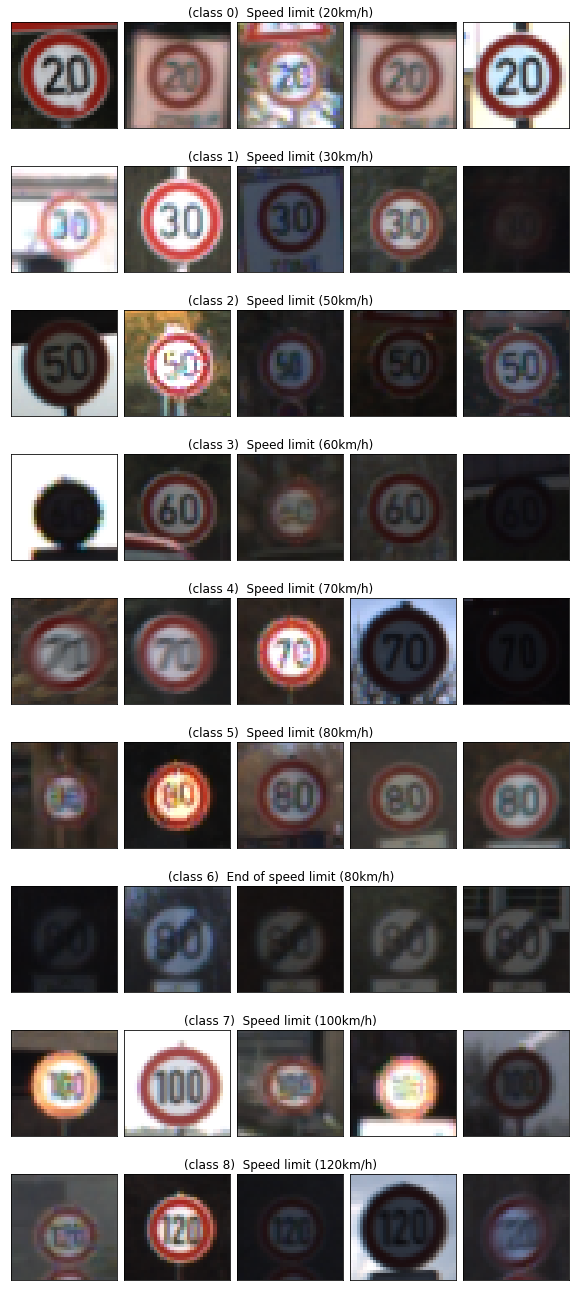

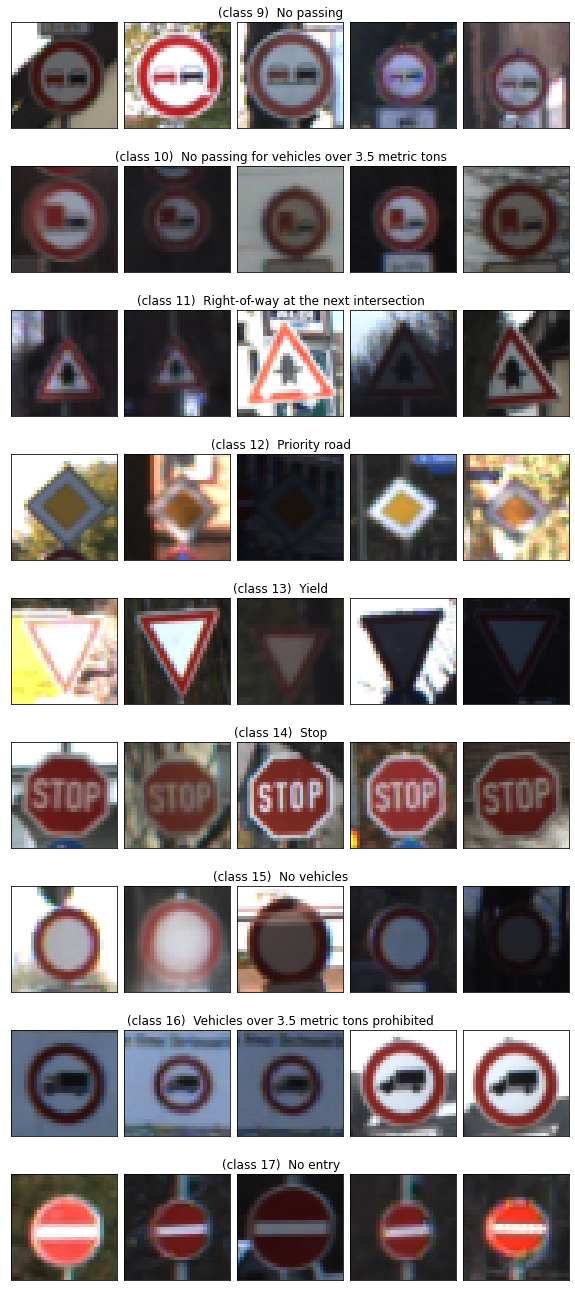

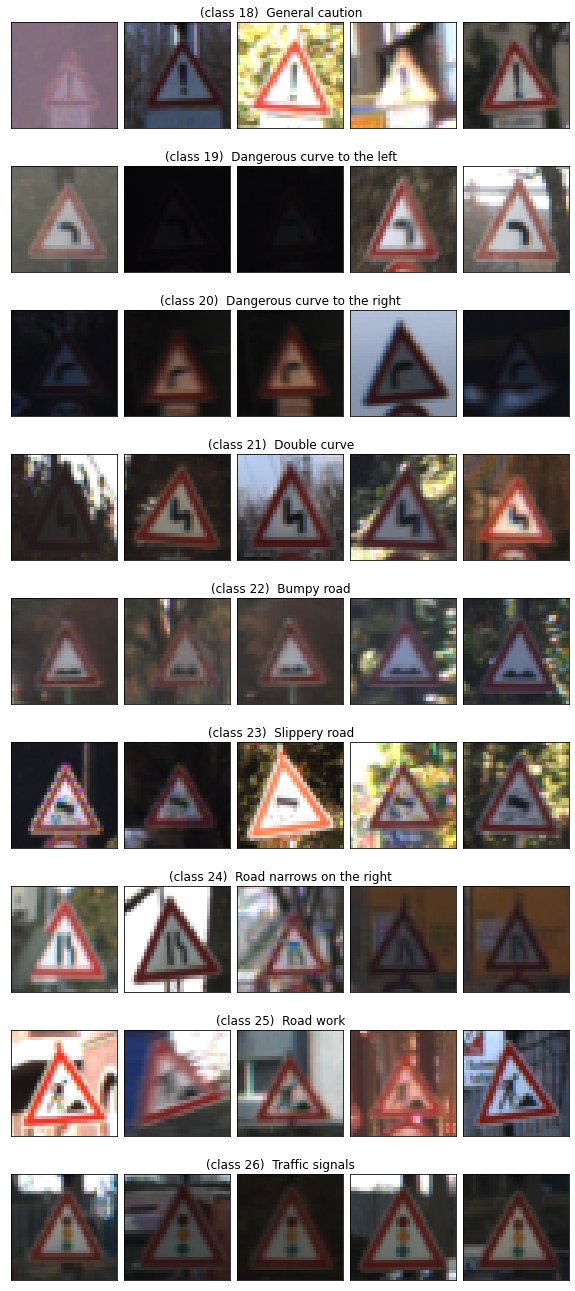

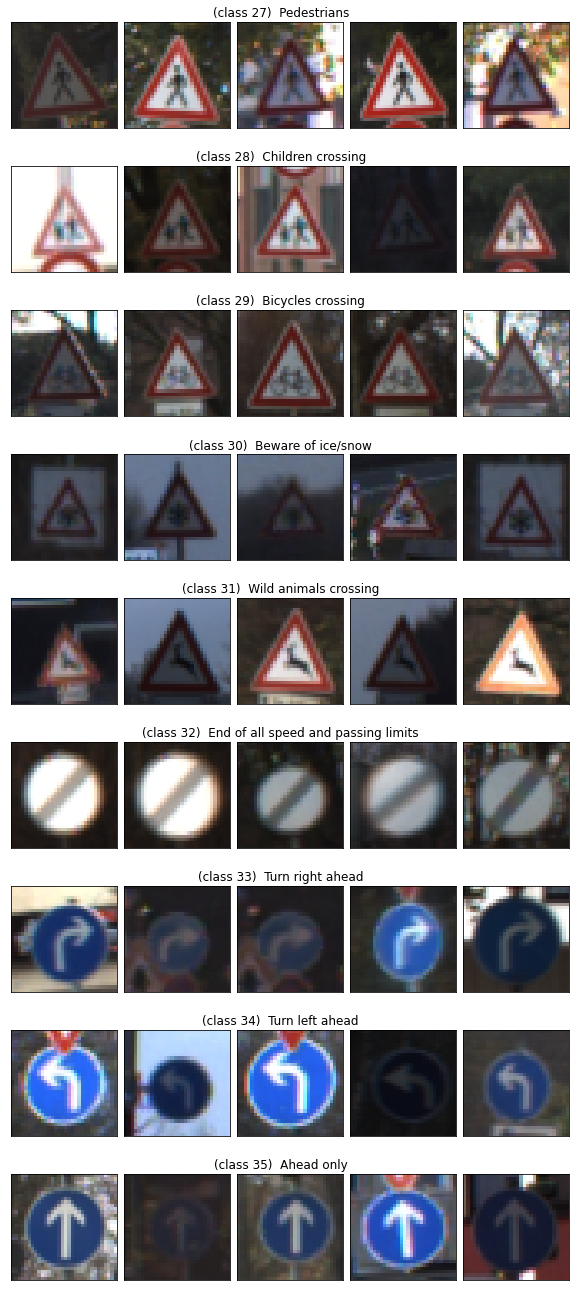

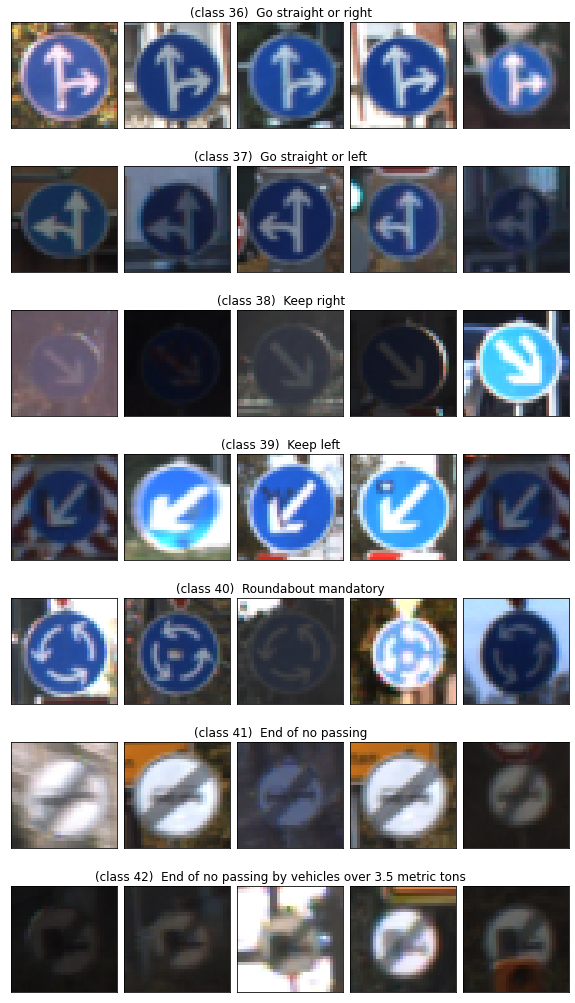

In [12]:
from traffic_sign_classifier.visualization import grid_visu

grid_visu(X_train, labels=y_train, sample_size=5, categories_per_fig=9, # , categories=range(10),
          label_to_name=class2label,
          shuffle=True, output_dir_path="./output/previews")

#### Categories/classes distribution (in train/validation/test)

In [13]:
# Grouping dataset by categories using the labels
category_grouped_datasets = {} # A dictionary per datatset grouping the sample with their attributes
for dataset, data_ in [ ("train", y_train), ("test", y_test), ("validation", y_valid)]:
    print(f"{dataset} data set size -> {len(data_)}")
    category_grouped_datasets[dataset] = group_by_category(data_) 

train data set size -> 34799
test data set size -> 12630
validation data set size -> 4410


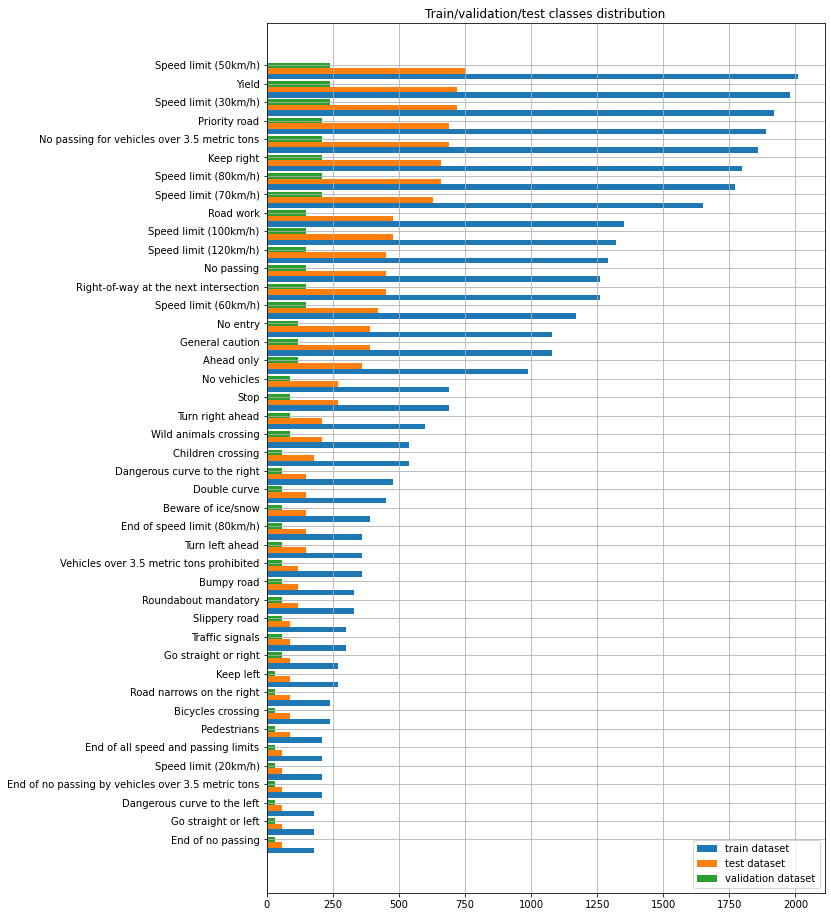

In [14]:
# Categories/classese distribution (in train/validation/test)
from collections import defaultdict
offset = defaultdict(lambda: [])
plt.figure(figsize=(10, 16))
bar_width = 0.3
width_offset = 0
    
for dataset, by_category in  category_grouped_datasets.items():
    # Plotting 
    categories, sizes = zip(*[(category, len(items)) for category, items in sorted(by_category.items(), key=lambda x: len(x[1]), reverse=False)])
    plt.barh([width_offset + item for item in range(len(categories))], sizes, height=bar_width,
             tick_label=[class2label.get(item, item) for item in categories],
             label=f"{dataset} dataset")
    width_offset += bar_width
plt.legend()
plt.title(f"Train/validation/test classes distribution")
plt.grid()
# Saving the figure to a file (png)
plt.savefig(os.path.join(output_dir, "classes_distribution.png"))

## Pre-process the Data Set

Minimally, the image data should be normalized so that the data has mean zero and equal variance. An apporximation is done by centralizing and scaling impemented as a preprocessing layers of the neural network (see `preprocessing_layers` intialization in  Model architecture section).

During the training a data augmentation layers are used to augment the data making the model a bit more robust to some transformation change/range.

In [15]:
from tensorflow.keras.layers import RandomRotation, Rescaling, Resizing, GaussianNoise
from tensorflow.keras import Sequential
import tensorflow as tf
from functools import reduce

In [16]:
# Prepare categories with few example to augment
# TODO: cleanup no need to sort here (because of the used threshold)
to_augment = {category: items for category, items in 
              sorted(category_grouped_datasets["train"].items(), key=lambda x: len(x[1])) if len(items)< 250}


In [17]:
to_augment_items = reduce(lambda x, y: x+y, to_augment.values()) 

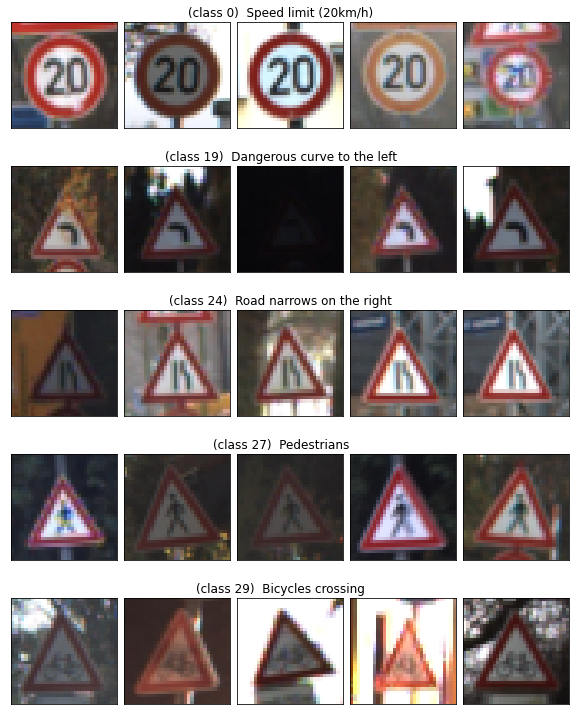

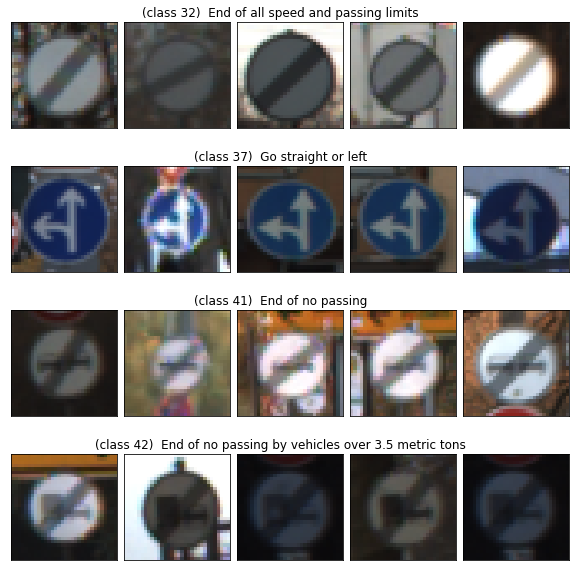

In [18]:
# Visualize items to augment

grid_visu(X_train[to_augment_items], labels=y_train[to_augment_items], sample_size=5, categories_per_fig=5,
          label_to_name=class2label,
          shuffle=True, output_dir_path="./output/to_augment")

### Generating and balancing data

In [19]:
# TO-Test: shuffle the data set to augment
# TODO upsampling to the wished item per class

In [20]:
# X_train[to_augment_items]
check_sample = y_train[to_augment_items]
check_sample.shape
np.argwhere( 1 - (check_sample[1:] - check_sample[:-1] == 0) == 1)

array([[ 179],
       [ 359],
       [ 539],
       [ 749],
       [ 959],
       [1169],
       [1379],
       [1619]])

In [21]:
# TODO: generate data and check the distribution balancing
# TODO: generate balanced data seed before using it for the data generation

# Define augmentation layers 
augmentation_layers = [
    RandomRotation(.04), 
    GaussianNoise(1, 0)
    ]

augmentation = Sequential(augmentation_layers)

augmented = (tf.data.Dataset.from_tensor_slices((X_train[to_augment_items], y_train[to_augment_items])).
             batch(64).map(lambda x, y: (augmentation(x), y),  num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
            )


Counter({37: 180, 19: 180, 0: 24})


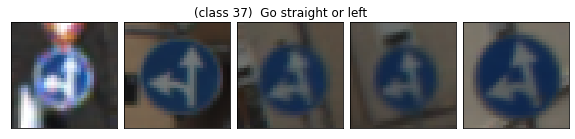

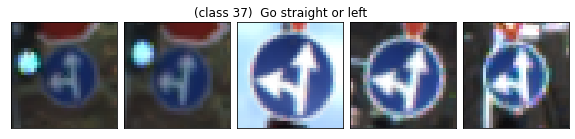

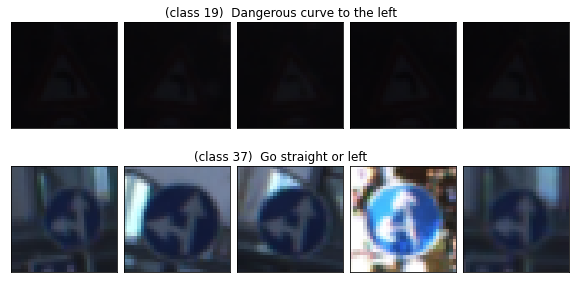

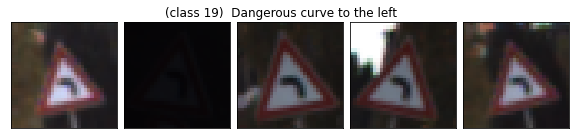

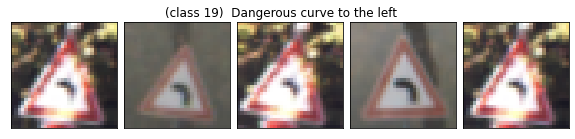

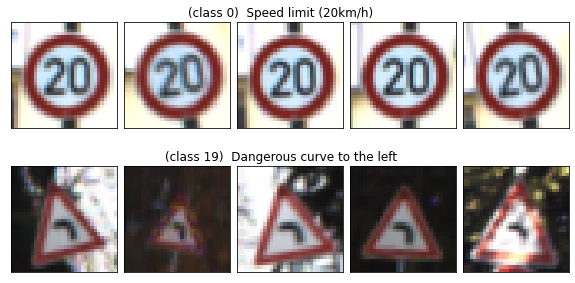

In [22]:
dataset_iterator = iter(augmented)
offset = 0
from collections import Counter
categories_counter = Counter()
for _ in range(6):
    if dataset_iterator:
        batch_X, batch_y = next(dataset_iterator)
        categories_counter.update(np.array(batch_y))
        grid_visu(np.array(batch_X), labels=np.array(batch_y), sample_size=5, categories_per_fig=5,
              label_to_name=class2label,
              shuffle=True, output_dir_path="./output/augmentation_output")
        # update offset 
        offset += len(batch_y)
        
print(categories_counter)
        

## Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


Model requirements:

To meet specifications, the validation set accuracy will need to be at least 0.93.

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

An example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

In [23]:
# from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import RandomRotation, Rescaling, Resizing, GaussianNoise

### Model Architecture

Le Net is chosen to be the baseline architecture. Augmentation and slightly variated architecture are evaluated for performance gain.

In [24]:
from traffic_sign_classifier.nn.lenet import LeNet
from datetime import datetime


In [25]:
preprocessing_layers = [
  Resizing(32, 32),
  Rescaling(scale=1./127.5, offset=-1)
]

In [26]:
# Setting up networks (and models) to compare
# TODO: add a Gray-Level model

logits = False # to append a Softmax activation ! set to true to keep the logits output

networks = {"tsc_lenet_with_augmentation": LeNet(categ_nbr=n_classes, logits=logits,
                                                 preprocessing_layers = preprocessing_layers,
                                                 augmentation_layers= [RandomRotation(0.1)],
                                                 name="tsc_lenet_with_augmentation"),
            "tsc_lenet": LeNet(categ_nbr=n_classes, logits=logits,
                               preprocessing_layers = preprocessing_layers,
                               name="tsc_lenet")
           }

In [27]:
# init models
for name , network in  networks.items():
    # setup model with arbitrary image size as input (arch. already setup to resize)
    print(f"building (models) for {name}")
    network.build_models(input_=tf.keras.Input(shape=(None, None, 3)))
    network.model.summary()
    network.pred_model.summary()


building (models) for tsc_lenet_with_augmentation
Model: "tsc_lenet_with_augmentation.training"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 random_rotation_1 (RandomRo  (None, 32, 32, 3)        0         
 tation)                                                         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6

# Add loss and compile model

In [28]:
optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

for _, network in  networks.items():
    network.compile_model(optimizer=optimizer, metrics=["accuracy"])

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validationsets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [29]:
assert(set(y_train)==set(y_valid)) # a sanity check that all the labels appear in both train and validation

y_train_categorical = to_categorical(y_train)
y_valid_categorical = to_categorical(y_valid)

In [30]:
# Sanity check
assert y_train_categorical.shape[1] == y_valid_categorical.shape[1]

In [31]:
y_train_categorical.shape

(34799, 43)

In [32]:
from collections import defaultdict

history = defaultdict(lambda: [])  # to support interactive training: multi-round of multiple epochs.

# Tensor board setup
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [33]:
EPOCHS = 20
BATCH_SIZE = 256 # to variate the batch_size

# Train all the test networks (sequentially)

for name, network in networks.items():
    print(f"training -> {name}")
    history[name].append(network.model.fit(X_train,  y_train_categorical,
        validation_data=(X_valid,  y_valid_categorical), shuffle=True, # probably better to shuffle externally
        epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[tensorboard_callback]))

training -> tsc_lenet_with_augmentation
Epoch 1/20
136/136 [==============================] - 6s 26ms/step - loss: 1.6532 - accuracy: 0.5310 - val_loss: 2.2055 - val_accuracy: 0.4190
Epoch 2/20
136/136 [==============================] - 4s 27ms/step - loss: 0.5618 - accuracy: 0.8210 - val_loss: 1.4263 - val_accuracy: 0.5998
Epoch 3/20
136/136 [==============================] - 4s 26ms/step - loss: 0.3890 - accuracy: 0.8761 - val_loss: 0.5041 - val_accuracy: 0.8644
Epoch 4/20
136/136 [==============================] - 3s 22ms/step - loss: 0.2914 - accuracy: 0.9078 - val_loss: 0.5832 - val_accuracy: 0.8696
Epoch 5/20
136/136 [==============================] - 3s 20ms/step - loss: 0.2446 - accuracy: 0.9207 - val_loss: 0.4381 - val_accuracy: 0.8941
Epoch 6/20
136/136 [==============================] - 3s 20ms/step - loss: 0.2116 - accuracy: 0.9324 - val_loss: 0.4112 - val_accuracy: 0.9079
Epoch 7/20
136/136 [==============================] - 3s 20ms/step - loss: 0.1904 - accuracy: 0.9370 -

In [34]:
history.keys()

dict_keys(['tsc_lenet_with_augmentation', 'tsc_lenet'])

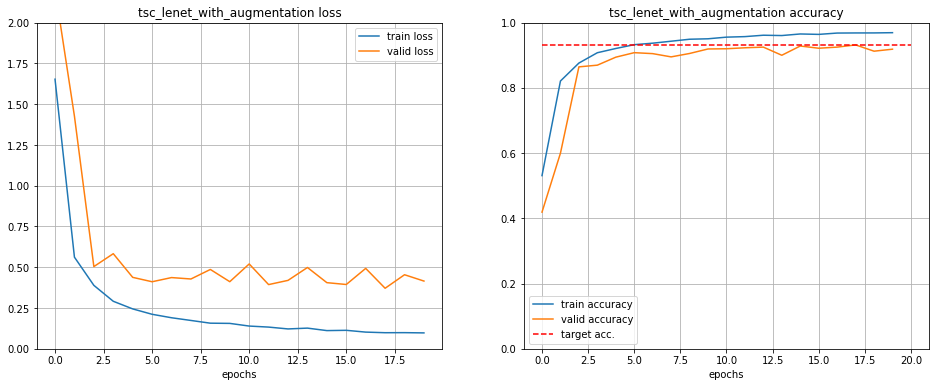

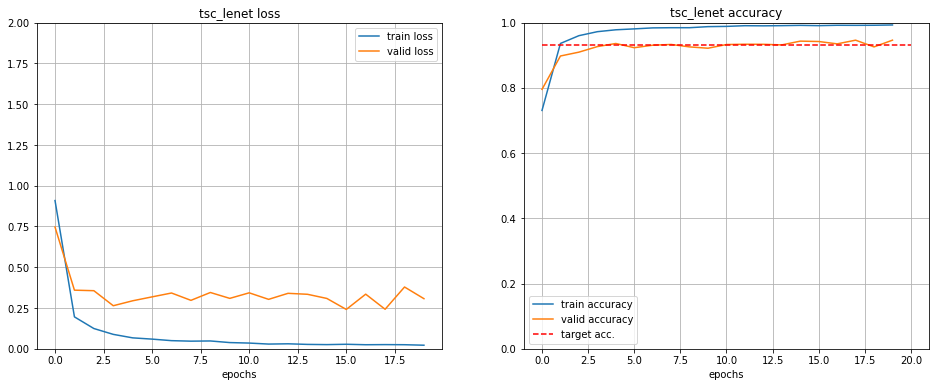

In [35]:
# Training summary/plots generation
# TODO: transpose to compare arch/models

from functools import reduce

summaries = {
    nn: {
        metric: {
            "train": reduce(lambda x, y: x + y, [x.history[metric] for x in history]),
            "valid": reduce(
                lambda x, y: x + y, [x.history[f"val_{metric}"] for x in history]
            ),
        }
        for metric in ["loss", "accuracy"]
    }
    for nn, history in history.items()
}

for nn, summary in summaries.items():

    plt.figure(figsize=(16, 6))

    for metric, ax in zip(
        summary.keys(), [plt.subplot(1, 2, idx) for idx in range(1, 3)]
    ):
        for set_label, values in summary[metric].items():
            ax.plot(values, label=f"{set_label} {metric}")
            ax.set_xlabel("epochs")
            ax.grid(visible=True)
            ax.set_title(f"{nn} {metric}")
        if metric == "accuracy":
            ax.set_ylim((0, 1))
            ax.hlines(
                0.93,
                0,
                len(values),
                color="red",
                linestyle="dashed",
                label="target acc.",
            )
        else:
            ax.set_ylim((0, 2))
        ax.legend()
    # Saving the figure to a file (png)
    plt.savefig(f"./output/{nn}_training_session.png")

In [36]:
# Accuracy on train, validation (and test) sets

def accuracy_classes(prediction, gt):
    assert len(prediction) == len(gt)
    return np.sum(prediction == gt) / len(gt)


def accuracy(prediction, gt):
    return accuracy_classes(np.argmax(prediction, axis=1), gt)

# TODO -> add pred. accuracy to the model
for _, network in networks.items(): 
    print(f"\n{network._name}:\n")
    print(f"  Accuracy on the Train set =  {accuracy(network.pred_model(X_train), y_train)}")
    print(f"  Accuracy on the Valid. set = {accuracy(network.pred_model(X_valid), y_valid)}")
    # Test set accuracy
    print(f"  Accuracy on the Test set = {accuracy(network.pred_model(X_test), y_test)}")


tsc_lenet_with_augmentation:

  Accuracy on the Train set =  0.9921836834391793
  Accuracy on the Valid. set = 0.9185941043083901
  Accuracy on the Test set = 0.9115597783056215

tsc_lenet:

  Accuracy on the Train set =  0.9981896031495158
  Accuracy on the Valid. set = 0.9462585034013605
  Accuracy on the Test set = 0.9390340459224069


## Select the "best" model (based on validation)

In [37]:
# Select the model based on the validation perf.
model_acc_sorted = sorted([ (model, accuracy(network.pred_model(X_valid), y_valid)) for model, network in networks.items()], key= lambda x:x[1], reverse=True)
model_acc_sorted

[('tsc_lenet', 0.9462585034013605),
 ('tsc_lenet_with_augmentation', 0.9185941043083901)]

## Inspect validation perf.

In [38]:
model = networks[model_acc_sorted[0][0]]

In [39]:
model.predict(X_valid)[:2]

array([[8.7283972e-08, 9.9085031e-05, 1.2705412e-07, 4.5091120e-10,
        6.2281051e-09, 5.3526126e-09, 8.4763842e-06, 4.4775611e-06,
        2.7404770e-09, 3.8452777e-07, 9.2516240e-13, 1.0152912e-06,
        1.2814395e-07, 2.9862917e-07, 1.0296223e-11, 2.3828989e-07,
        2.2432031e-08, 1.1927685e-11, 1.7122886e-10, 5.8361952e-13,
        8.7221714e-12, 1.1680351e-11, 2.0180538e-14, 1.3435288e-11,
        3.8532649e-11, 2.4331157e-09, 2.6420465e-11, 1.3478503e-12,
        4.9631154e-07, 3.3323604e-13, 9.1510716e-11, 6.7651514e-12,
        9.8351097e-01, 3.1670473e-07, 3.5907597e-08, 2.7863917e-08,
        2.3140846e-07, 6.8303918e-09, 2.6019589e-07, 1.7711745e-13,
        2.4730084e-04, 1.6098067e-02, 2.7903796e-05],
       [2.5216760e-03, 2.9931951e-03, 2.8098026e-05, 2.5686490e-05,
        1.4480938e-06, 1.2531736e-05, 1.2729624e-01, 7.8324359e-03,
        1.0816181e-03, 2.4637689e-03, 2.0816655e-07, 6.2213623e-04,
        6.7825342e-04, 1.6889283e-02, 2.8422526e-06, 1.2075461

In [40]:
def misclassified(model, images, gt):
    """ Returns the mis-classified item indices zipped
        with the predicted and the correct ground truth label 
    
    :param model: model to use for prediction
    :param images: images as a np.array with shape (N, 32, 32,3) 
    :param gt: label as integer of shape (N,)
    """
    predictions = np.argmax(model.predict(images), axis=1) # perform  prediction with the given modl
    misclassified_indices =  np.argwhere(predictions != gt).flatten()
    return np.array(list(zip(misclassified_indices, predictions[misclassified_indices], gt[misclassified_indices])))

In [41]:
valid_misclassified = misclassified(model, X_valid, y_valid)

In [42]:
print(len(valid_misclassified))

237


In [43]:
from traffic_sign_classifier.utils import load_signnames
index2label = load_signnames("./traffic-signs-data/signnames.csv")

In [44]:
from collections import defaultdict

valid_misclassified_by_pred = defaultdict(lambda:[]) # misclassified grouped by predicted class
valid_misclassified_by_gt = defaultdict(lambda:[]) # misclassified grouped by gt clas
for index, prediction, gt in valid_misclassified:
    valid_misclassified_by_pred[prediction].append((index, gt))
    valid_misclassified_by_gt[gt].append((index, prediction))
    # print(f"{index} pred.: {index2label.get(prediction)}, gt: {index2label.get(gt)}")

In [45]:
# Sorting the missclassification by category (first those with high error rate)
top_mis_nbr = 5 # number of the top misclassified category to summarize
sorted_misclassified = sorted([ (category, misclassifications)
                                          for category, misclassifications in valid_misclassified_by_gt.items()],
                                          key=lambda x: len(x[1]), reverse=True)
for category, misclassification in sorted_misclassified[:top_mis_nbr]:
    print(f"(id: {category}) {index2label.get(category)}, {len(misclassification)} uncorrectly classified: ")
    # Groupping the misclassification by predicted class
    grp = defaultdict(lambda:[])
    for item, predicted in misclassification:
        grp[predicted].append(item)
    for prediction, items in  grp.items():
        print(f"          {class2label.get(prediction, prediction)} -> {len(items)}")
        
    

(id: 21) Double curve, 32 uncorrectly classified: 
          Road work -> 5
          Bicycles crossing -> 1
          Wild animals crossing -> 23
          Slippery road -> 2
          Dangerous curve to the left -> 1
(id: 16) Vehicles over 3.5 metric tons prohibited, 30 uncorrectly classified: 
          End of no passing -> 30
(id: 24) Road narrows on the right, 22 uncorrectly classified: 
          Speed limit (120km/h) -> 22
(id: 5) Speed limit (80km/h), 21 uncorrectly classified: 
          Speed limit (50km/h) -> 19
          Speed limit (120km/h) -> 2
(id: 20) Dangerous curve to the right, 19 uncorrectly classified: 
          Slippery road -> 7
          Wild animals crossing -> 2
          Children crossing -> 4
          End of all speed and passing limits -> 1
          Road work -> 2
          Speed limit (60km/h) -> 1
          Priority road -> 1
          Right-of-way at the next intersection -> 1


## Misclassified sample visualization.

Visualizing the most freq. misclassified categories/classes

In [46]:
# most frequently missed categories
most_misclassified_categs, _ = zip(*sorted_misclassified)

In [47]:
# Remark the last contrast (dark images) (histogram equalization could be part of the processing for the )
# Also for the 

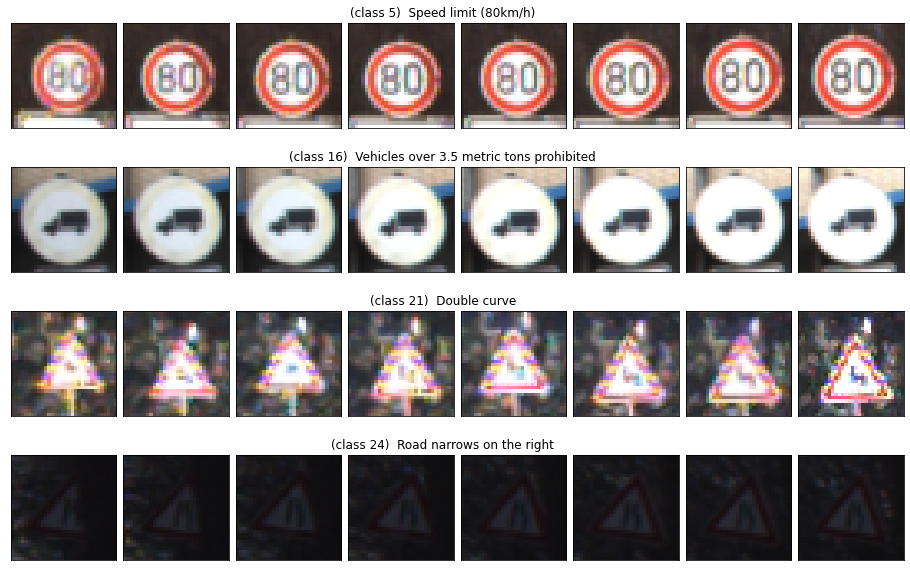

In [48]:
# TODO: fix subfigure bug
grid_visu(X_valid[valid_misclassified[:, 0]], labels=y_valid[valid_misclassified[:, 0]],
                 sample_size=8, categories= most_misclassified_categs[:4], label_to_name=class2label,
         output_dir_path="./output/misclassified")

In [49]:
from traffic_sign_classifier.utils import inspect_prediction
hit = inspect_prediction(model, X_valid, y_valid)

In [50]:
np.sum(hit.astype(int))/len(hit)

0.9462585034013605

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [51]:
from typing import List
from glob import glob

import cv2

test_paths = [image_path for image_path in glob("./examples/test_sample/*.png")]

# For convinience and batch/faster prediction that we resize the new image to (32x32)
# 32x32 resizing is part of the preprocessing for prediction though!

def load_data(paths: List[str], label_extractor=lambda path: int(os.path.split(os.path.basename(path))[-1].split("_")[0])):
    """ A helper loading  the images from a list of paths 
    and extract the label from their path using the label extractor
    """ 
    for path in paths:
        yield  path, cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), (32,32)) , label_extractor(path)

In [52]:
# sample_test_image = cv2.cvtColor(cv2.imread(test_paths[-1]), cv2.COLOR_BGR2RGB)
# sample_test_image.reshape( [1] , sample_test_image.shape()
# As the resizing and scaling 
model.predict(np.expand_dims(cv2.cvtColor(cv2.imread(test_paths[-1]), cv2.COLOR_BGR2RGB), axis=0))

array([[5.74228498e-10, 2.79951024e-07, 7.72894099e-02, 3.31658637e-13,
        1.24307509e-09, 9.54808684e-07, 2.75890801e-13, 4.36559802e-08,
        1.05325384e-11, 3.41564559e-13, 1.12320040e-05, 3.18119528e-05,
        3.37630757e-10, 1.73789782e-14, 1.89559985e-17, 2.67874725e-13,
        6.21779321e-13, 1.24147904e-15, 1.30391340e-11, 1.02548836e-13,
        1.38663738e-08, 3.81042291e-08, 5.47024571e-16, 2.74094150e-11,
        5.95794383e-08, 1.51783724e-11, 4.76637891e-15, 5.97147819e-13,
        3.15639138e-12, 1.19334462e-08, 1.45614464e-07, 1.64219928e-05,
        1.26067831e-15, 1.06334407e-12, 2.28562252e-10, 9.50722834e-12,
        8.98782425e-17, 7.96275117e-07, 1.90860874e-07, 5.87604687e-11,
        9.22648668e-01, 7.35224463e-14, 3.83966192e-09]], dtype=float32)

In [53]:
model.predict(cv2.cvtColor(cv2.imread(test_paths[-1]), cv2.COLOR_BGR2RGB))

<tf.Tensor: shape=(1, 43), dtype=float32, numpy=
array([[5.74228443e-10, 2.79950996e-07, 7.72894770e-02, 3.31659884e-13,
        1.24307253e-09, 9.54808570e-07, 2.75890774e-13, 4.36560583e-08,
        1.05325575e-11, 3.41564505e-13, 1.12320031e-05, 3.18119783e-05,
        3.37630729e-10, 1.73789426e-14, 1.89559968e-17, 2.67875213e-13,
        6.21779267e-13, 1.24148359e-15, 1.30391331e-11, 1.02548436e-13,
        1.38663721e-08, 3.81042256e-08, 5.47024518e-16, 2.74094115e-11,
        5.95793210e-08, 1.51783707e-11, 4.76637848e-15, 5.97146627e-13,
        3.15639116e-12, 1.19334453e-08, 1.45614592e-07, 1.64219909e-05,
        1.26067810e-15, 1.06334191e-12, 2.28561781e-10, 9.50722747e-12,
        8.98782359e-17, 7.96274264e-07, 1.90861030e-07, 5.87603438e-11,
        9.22648549e-01, 7.35224395e-14, 3.83966858e-09]], dtype=float32)>

In [54]:
test_paths, test_images , test_labels =zip(* load_data(test_paths))

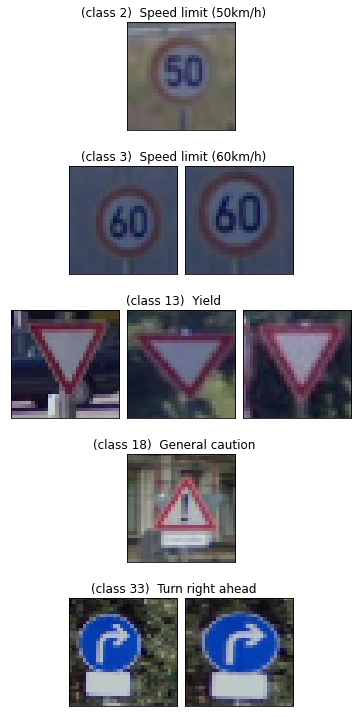

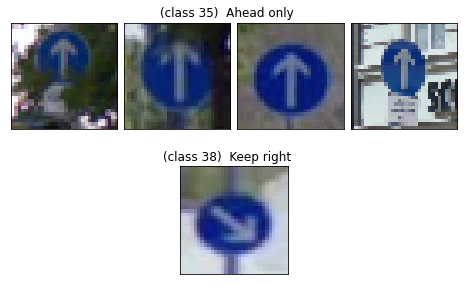

In [55]:
# Todo center the visualization
grid_visu(test_images, test_labels, sample_size=4, label_to_name=class2label)

In [56]:
# predict the images (in batch)
prediction = model.predict(np.array(test_images))

In [57]:
from traffic_sign_classifier.nn.lenet import softmax
tf.nn.top_k(softmax(prediction), k=5)

TopKV2(values=<tf.Tensor: shape=(14, 5), dtype=float32, numpy=
array([[0.06078682, 0.02236222, 0.02236222, 0.02236222, 0.02236222],
       [0.06078682, 0.02236222, 0.02236222, 0.02236222, 0.02236222],
       [0.06078682, 0.02236222, 0.02236222, 0.02236222, 0.02236222],
       [0.06078558, 0.02236245, 0.02236244, 0.02236228, 0.02236225],
       [0.0490604 , 0.02562723, 0.02377244, 0.02279509, 0.02278737],
       [0.04392425, 0.03060813, 0.02275543, 0.02274501, 0.02269233],
       [0.06074744, 0.02237787, 0.0223628 , 0.0223628 , 0.0223628 ],
       [0.06078682, 0.02236222, 0.02236222, 0.02236222, 0.02236222],
       [0.06078682, 0.02236222, 0.02236222, 0.02236222, 0.02236222],
       [0.06078456, 0.02236312, 0.02236225, 0.02236225, 0.02236225],
       [0.05741297, 0.02326198, 0.02277635, 0.02246112, 0.02244908],
       [0.04890976, 0.02529529, 0.02505105, 0.02254549, 0.02252167],
       [0.06078682, 0.02236222, 0.02236222, 0.02236222, 0.02236222],
       [0.05646361, 0.02420331, 0.022423

### Predict the Sign Type for Each Image

In [58]:
# To move to LeNet (class) as a method
from typing import Iterable

def predict_paths(paths: Iterable[str]=test_paths, top_k=5):
    """ Predict a list of image paths """
    for path, image, label  in load_data(paths):
        image = image.reshape([1] + list(image.shape))
        prediction = (model.predict(image)).flatten()
        pred_categ = np.argmax(prediction)
        print(f" {path}: gt: {label} -> predicted category ({pred_categ}:{class2label[pred_categ]}) ")
        if top_k is not None:
            for softmax_output, category in sorted(zip(softmax(prediction), range(len(prediction))), reverse=True)[:top_k]:
                print(f"        {category} {softmax_output} {class2label[category]} -> {category}")
        yield path, label, pred_categ
        

In [59]:
ext_paths, ext_gt, ext_pred = zip(*predict_paths(test_paths))

 ./examples/test_sample/13_3.png: gt: 13 -> predicted category (13:Yield) 
        13 0.06078681722283363 Yield -> 13
        42 0.02236221916973591 End of no passing by vehicles over 3.5 metric tons -> 42
        41 0.02236221916973591 End of no passing -> 41
        40 0.02236221916973591 Roundabout mandatory -> 40
        39 0.02236221916973591 Keep left -> 39
 ./examples/test_sample/13_1.png: gt: 13 -> predicted category (13:Yield) 
        13 0.06078681722283363 Yield -> 13
        42 0.02236221916973591 End of no passing by vehicles over 3.5 metric tons -> 42
        41 0.02236221916973591 End of no passing -> 41
        40 0.02236221916973591 Roundabout mandatory -> 40
        39 0.02236221916973591 Keep left -> 39
 ./examples/test_sample/38_1.png: gt: 38 -> predicted category (38:Keep right) 
        38 0.06078681722283363 Keep right -> 38
        42 0.02236221916973591 End of no passing by vehicles over 3.5 metric tons -> 42
        41 0.02236221916973591 End of no passing -> 

### Analyze Performance

In [60]:
print (f" accuracy on the new sample -> {100*accuracy_classes(np.array(ext_gt), np.array(ext_pred))}%")

 accuracy on the new sample -> 57.14285714285714%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [61]:
tf.nn.top_k(softmax(prediction), k=5) # also matches the one generated by `predict_paths` helper

TopKV2(values=<tf.Tensor: shape=(14, 5), dtype=float32, numpy=
array([[0.06078682, 0.02236222, 0.02236222, 0.02236222, 0.02236222],
       [0.06078682, 0.02236222, 0.02236222, 0.02236222, 0.02236222],
       [0.06078682, 0.02236222, 0.02236222, 0.02236222, 0.02236222],
       [0.06078558, 0.02236245, 0.02236244, 0.02236228, 0.02236225],
       [0.0490604 , 0.02562723, 0.02377244, 0.02279509, 0.02278737],
       [0.04392425, 0.03060813, 0.02275543, 0.02274501, 0.02269233],
       [0.06074744, 0.02237787, 0.0223628 , 0.0223628 , 0.0223628 ],
       [0.06078682, 0.02236222, 0.02236222, 0.02236222, 0.02236222],
       [0.06078682, 0.02236222, 0.02236222, 0.02236222, 0.02236222],
       [0.06078456, 0.02236312, 0.02236225, 0.02236225, 0.02236225],
       [0.05741297, 0.02326198, 0.02277635, 0.02246112, 0.02244908],
       [0.04890976, 0.02529529, 0.02505105, 0.02254549, 0.02252167],
       [0.06078682, 0.02236222, 0.02236222, 0.02236222, 0.02236222],
       [0.05646361, 0.02420331, 0.022423

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images



In [62]:
for layer in model.pred_model.layers:
    print(layer.name)

input_2
resizing
rescaling
conv2d_2
batch_normalization_2
max_pooling2d_2
conv2d_3
batch_normalization_3
max_pooling2d_3
flatten_1
dense_3
dense_4
dense_5


In [63]:
def visualize_feature_map_output(images, model, layer_name, images_per_figure=5):
    """ Visualize the feature map output
    
    :param images: images np.array to be fed to the network (for which the feature map will be produced)
    :param model: prediction model
    :param layer_name: layer_name as the selector for the layer output/feature map to be visualized
    :param images_per_figure: the number of image to group by figure
    
    """

    activation_model = tf.keras.Model(
        model.pred_model.input, model.pred_model.get_layer(layer_name).output
    )
    # TODO: replace images, model, layer_name with the activation model output (limit the helper to only visualization)
    activation_output = activation_model.predict(np.array(images)).transpose(0, 3, 1, 2)

    feature_map_nbr = activation_output.shape[1]
    offset = 0
    for idx, grp in enumerate(
        [
            activation_output[i : i + images_per_figure]
            for i in range(0, activation_output.shape[0], images_per_figure)
        ]
    ):
        subfigs = plt.figure(
            # constrained_layout=True,
            figsize=(2 * grp.shape[1], 2 * len(grp)),
            tight_layout=False,
        ).subfigures(grp.shape[0], 1, wspace=0.01)

        if not isinstance(subfigs, Iterable):
            subfigs = [subfigs]
            
        
        for image_idx, ft_map, fig in zip(range(grp.shape[0]), grp, subfigs):
            grid = ImageGrid(
                fig,
                111,
                nrows_ncols=(1, feature_map_nbr),
                axes_pad=0.4,
            )
            for ax, ft_map_idx in zip(grid, range(ft_map.shape[0])):
                title = f"FeatureMap {ft_map_idx}"
                # print("ft_map",  ft_map[idx].shape)
                if idx is not None:
                    show_image(ax, ft_map[ft_map_idx], title)

            fig.suptitle(
                f"layer: {layer_name}, image: {offset + image_idx} ",
                fontsize="large",
            )
        offset += len(grp)

In [64]:
from mpl_toolkits.axes_grid1 import ImageGrid
from traffic_sign_classifier.visualization import show_image


In [65]:
conv_layer_names =  [layer.name for layer in  model.pred_model.layers if  layer.name.startswith("conv")]

In [66]:
conv_layer_names

['conv2d_2', 'conv2d_3']

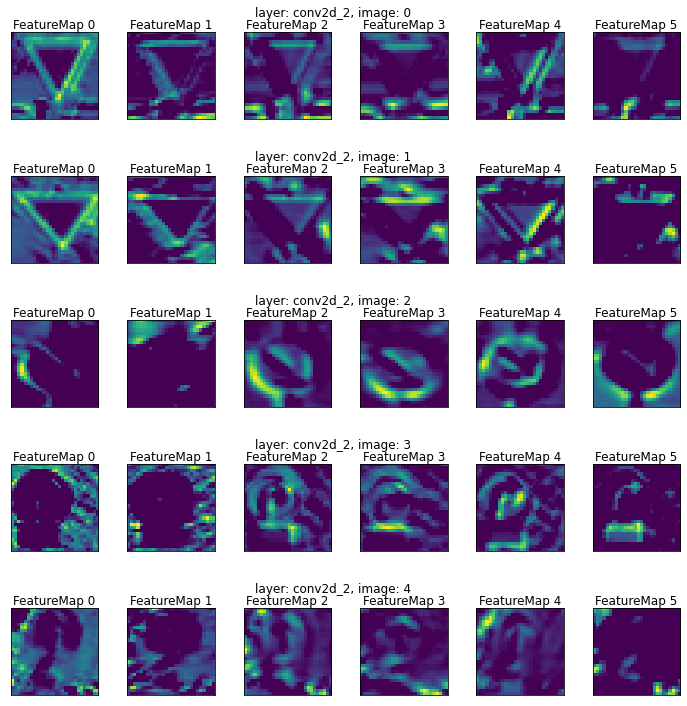

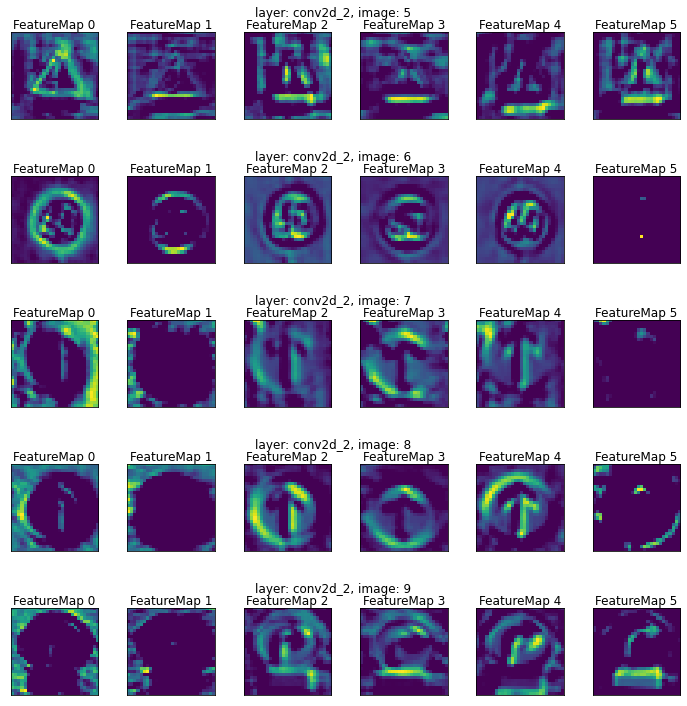

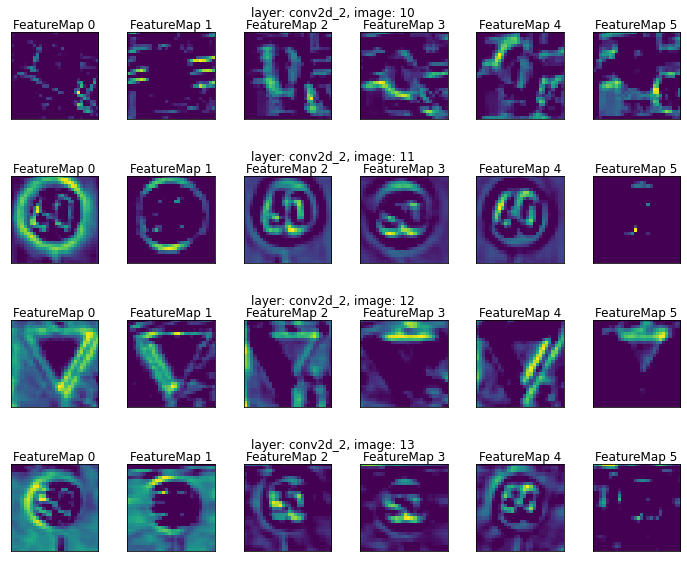

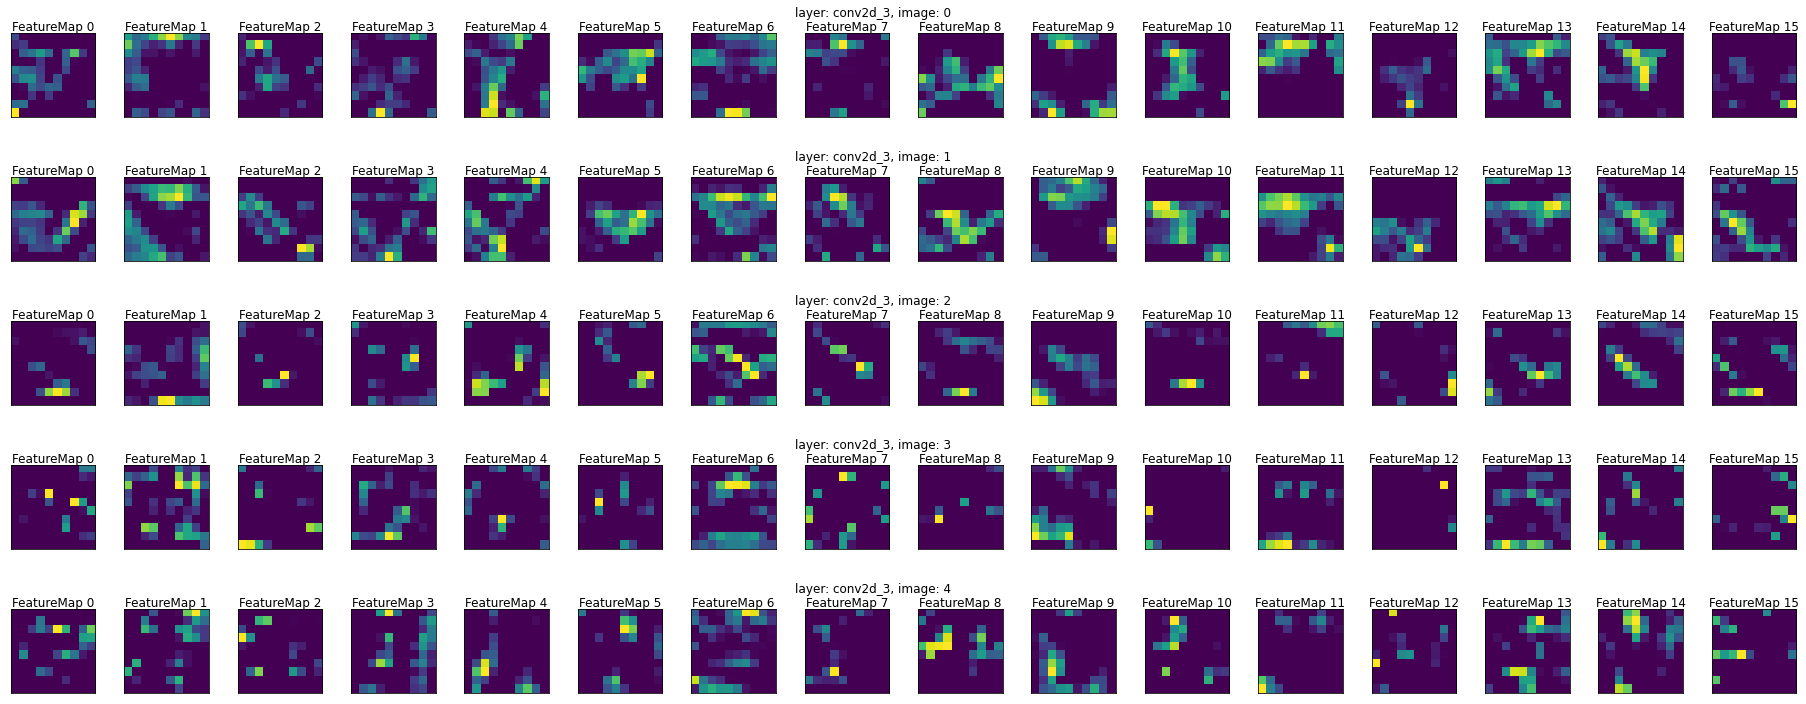

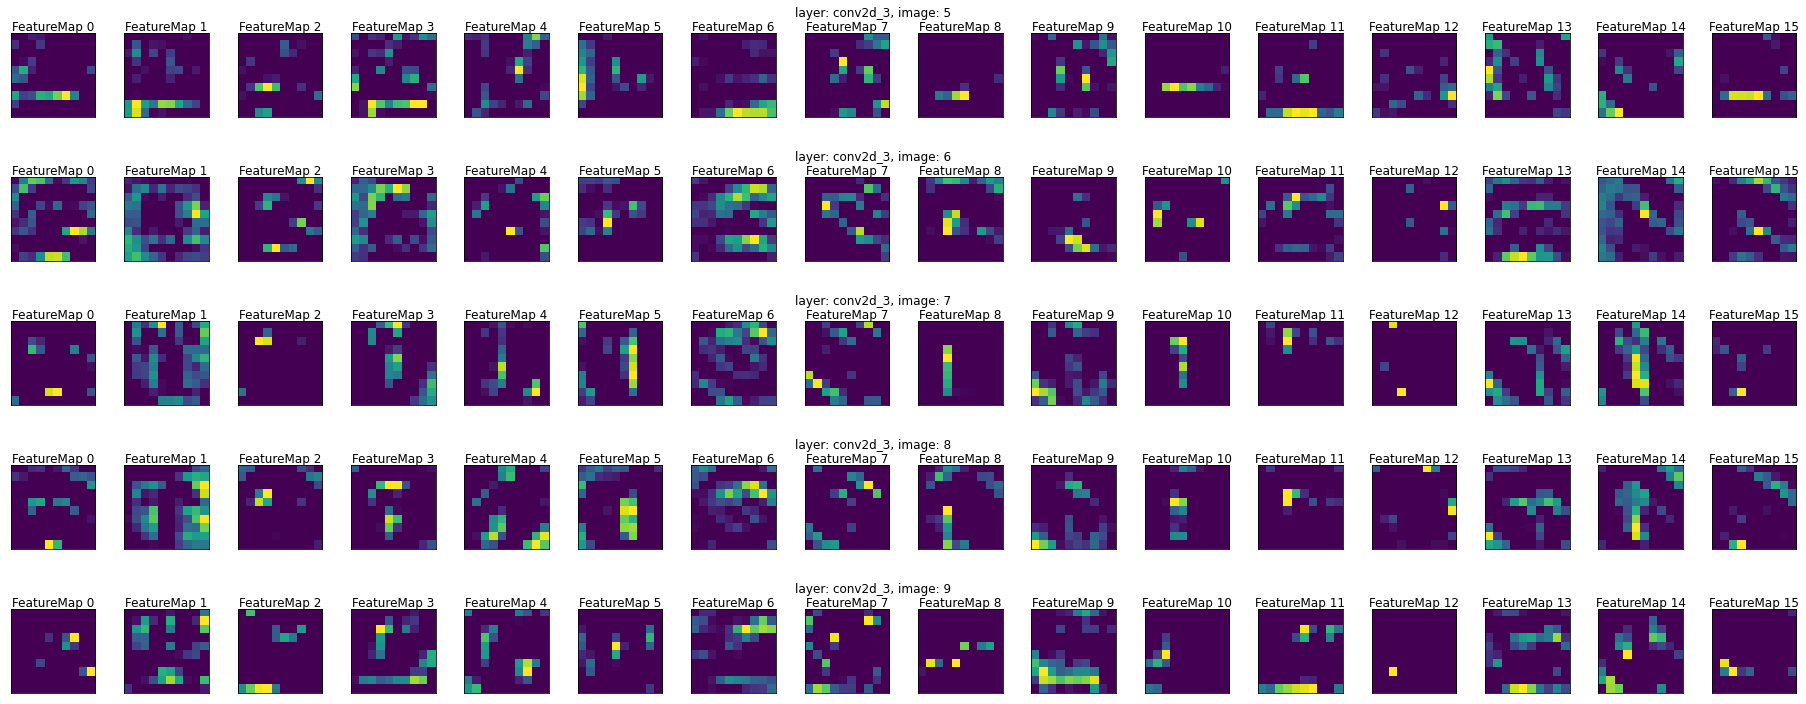

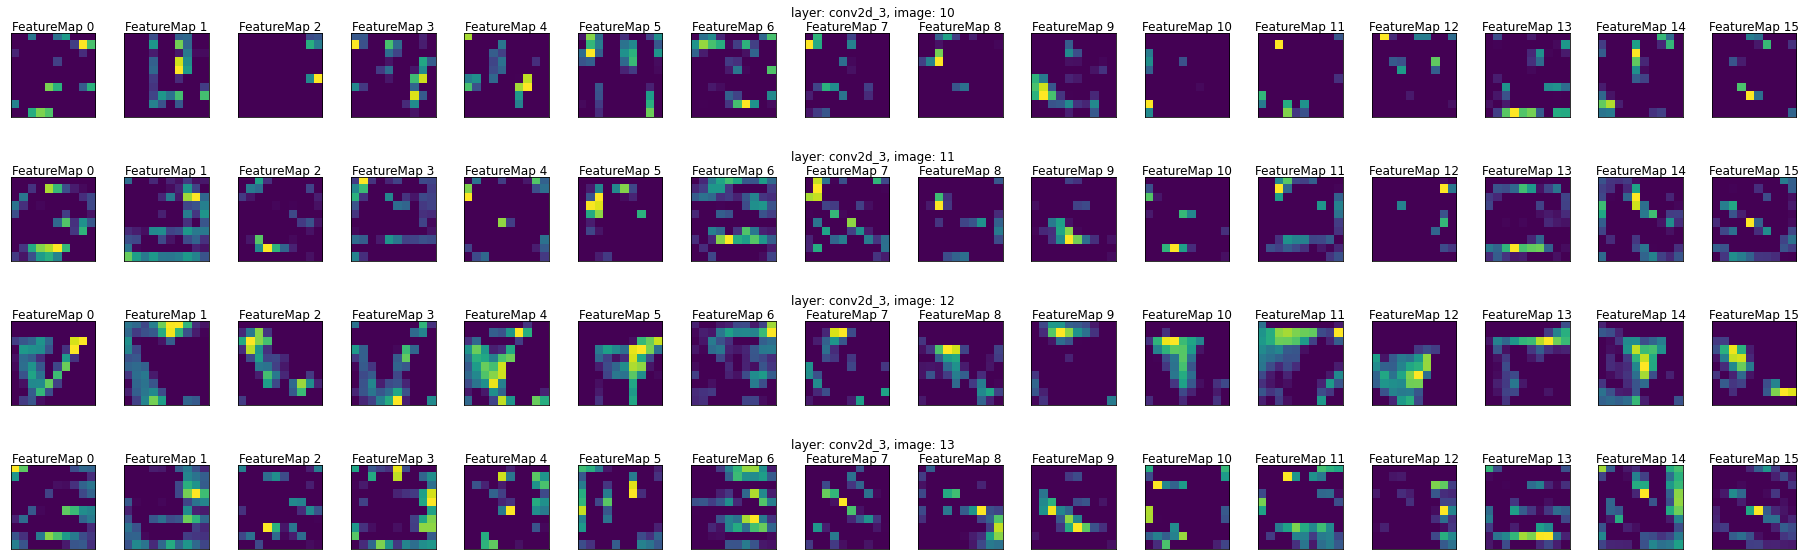

In [67]:
for layer_name in  conv_layer_names:
    visualize_feature_map_output(test_images, model, layer_name)